# Importing the required modules

In [91]:
# modules used for data handling and
# manipulation
import numpy as np
import pandas as pd

# modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Reading the data

In [92]:
flight_df = pd.read_csv("DelayData.csv")

In [93]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201664 entries, 0 to 1201663
Data columns (total 61 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   depdelay                 1201664 non-null  int64  
 1   arrdelay                 1198458 non-null  float64
 2   scheduleddepartdatetime  1201664 non-null  object 
 3   origin                   1201664 non-null  object 
 4   dest                     1201664 non-null  object 
 5   uniquecarrier            1201664 non-null  object 
 6   marketshareorigin        1201664 non-null  float64
 7   marketsharedest          1201664 non-null  float64
 8   hhiorigin                1201664 non-null  float64
 9   hhidest                  1201664 non-null  float64
 10  nonhubairportorigin      1201664 non-null  int64  
 11  smallhubairportorigin    1201664 non-null  int64  
 12  mediumhubairportorigin   1201664 non-null  int64  
 13  largehubairportorigin    1201664 non-null 

# Converting dummies to ordinal values

Based on the column names, a few of the columns are already one-hot encoded. These include the following:
1. Temperature ranges: these columns are different temperature ranges and have a value of 1 when the `temperature` falls in the range. Otherwise, they have a value of 0. (`temp_ninfty_n10`, `temp_n10_0`, `temp_0_10`, `temp_10_20`, `temp_20_30`, `temp_30_40`, `temp_40_infty`)
2. Airport Connectivity Variables: these columns denote whether the origin and destination airports are hubs for some airline. It also categorises such hubs as small, medium, and large. (`nonhubairportorigin`, `smallhubairportorigin`, `mediumhubairportorigin`, `largehubairportorigin`, `nonhubairportdest`, `smallhubairportdest`, `mediumhubairportdest`, `largehubairportdest`)
3. Airline Connectivity Variables: these columns denote whether the origin and destination airports are hubs for the `uniquecarrier`. It also categorises such hubs as small, medium, and large. (`nonhubairlineorigin`, `smallhubairlineorigin`, `mediumhubairlineorigin`, `largehubairlineorigin`, `nonhubairlinedest`, `smallhubairlinedest`, `mediumhubairlinedest`, `largehubairlinedest`)


However, the variables in each of the above categories represent information that is ordered; hence, each of those different columns can be collectively represented as a single ordinal feature. Therefore, the following changes will be made for the respective categories:

1. For temperature range, a new column `temp_range` will be created, having seven categories: ninfty_n10, 10_0, 0_10, 10_20, 20_30, 40_infty.
2. For airport connectivity variables, two new columns will be created `hubairportorigin` and `hubairportdest`. Each of these columns will contain four categories: nonhub, smallhub, mediumhub, and largehub.
3. For airline connectivity variables, two new columns will be created `hubairlineorigin` and `hubairlinedest`. Each of these columns will contain four categories: nonhub, smallhub, mediumhub, and largehub.

All the previous columns will be dropped.

In [94]:
# extracting all dummy features from the respective categories.
cols = list(flight_df.columns)
temperature_range = cols[42:49]
airport_connectivity_origin = cols[10:14]
airport_connectivity_dest = cols[14:18]
airline_connectivity_origin = cols[18:22]
airline_connectivity_dest = cols[22:26]

In [95]:
# converts dummy columns into a single categorical feature.
def onehot2ordinal(new_colname: str, dummies: list, str2replace: str, sep = None):

    flight_df[new_colname] = pd.from_dummies(flight_df[dummies], 
                           default_category = np.nan,
                           sep = sep)
    if not sep:
       flight_df[new_colname] = flight_df[new_colname].astype(str).apply(lambda x: x.replace(str2replace, 
                                                                                             ''))

    flight_df.drop(dummies, axis = 1, inplace = True)

In [96]:
# applies the function to all the respective kinds of dummy features.
arguments = [["temp_range", temperature_range, None, "_"],
             ["hubairportorigin", airport_connectivity_origin, "airportorigin", None],
             ["hubairportdest", airport_connectivity_dest, "airportdest", None],
             ["hubairlineorigin", airline_connectivity_origin, "airlineorigin", None],
             ["hubairlinedest", airline_connectivity_dest, "airlinedest", None]]

for new_colname, dummies, str2replace, sep in arguments:
    
    onehot2ordinal(new_colname = new_colname, dummies = dummies,
                   str2replace = str2replace, sep = sep)

# Handling null values

In [97]:
def display_cols_wt_na():
   print(flight_df.isna().sum().loc[lambda x : x>0].sort_values(ascending = False)*100/len(flight_df))

In [98]:
display_cols_wt_na()

arrdelay           0.266797
temp_range         0.076477
temperature        0.038280
windspeed          0.038280
windspeedsquare    0.038280
windgustspeed      0.038280
dtype: float64


- The `arrdelay` column has approximately 2.6% null values. This column is also the target column and imputation would not be correct for the target column. All these rows with null values will be dropped.
- After dropping those rows we will check if the other columns yet have null values.

In [99]:
flight_df = flight_df[flight_df['arrdelay'].notna()]

In [100]:
display_cols_wt_na()

temp_range         0.076432
temperature        0.038383
windspeed          0.038383
windspeedsquare    0.038383
windgustspeed      0.038383
dtype: float64


- Now, we will impute the missing values in the `temperature`, `windspeed`, `windspeedsquare`, and `windgustspeed` with the mean of the columns.
- After the imputation of `temperature`, the values for temp_range will be derived.

In [101]:
def categorise_temp(temp):
    if temp <= -10:
        return "ninfty_n10"
    elif temp > -10 and temp <= 0:
        return "n10_0"
    elif temp > 0 and temp <= 10:
        return "0_10"
    elif temp > 10 and temp <= 20:
        return "10_20"
    elif temp > 20 and temp <= 30:
        return "n20_30"
    elif temp > 30 and temp <= 40:
        return "n30_40"
    else:
        return "40_infty"

In [102]:
to_impute_cols = ["temperature", "windspeed", "windspeedsquare", "windgustspeed"]

for col in to_impute_cols:
    flight_df[col] = flight_df[col].fillna(np.nanmean(flight_df[col]))
    if col == "temperature":
        flight_df["temp_range"] = flight_df.apply(lambda x: categorise_temp(x.temperature),
                                                  axis = 1)

In [103]:
display_cols_wt_na()

Series([], dtype: float64)


All the null values are handled.

# Encoding the categorical variables

- The column `scheduleddepartdatetime` has been already divided into its components with the following columns: `year`, `month`, `dayofmonth`, `dayofweek`, and `scheduledhour`. Therefore, it is redundant and must be dropped.
- The columns `originairportid` and `destairportid` are already represented in the `origin` and `dest` columns respectively. Therefore, those two columns are also redundant and must be dropped.

In [104]:
flight_df = flight_df.drop(columns = ["scheduleddepartdatetime",
                                      "originairportid",
                                      "destairportid",
                                      "originstate",
                                      "origincityname"],
                           axis = 1)

In [105]:
def bin_delay(delay):
    if delay <= 10:
        return "0-10"
    elif 10 < delay <= 20:
        return "10-20"
    elif 20 < delay <= 40:
        return "20-40"
    elif 40 < delay <= 60:
        return "40-60"
    elif delay > 60:
        return ">60"

In [106]:
flight_df["depdelay"] = flight_df.apply(lambda x: bin_delay(x.depdelay),
                                        axis = 1)
flight_df["arrdelay"] = flight_df.apply(lambda x: bin_delay(x.arrdelay),
                                        axis = 1)

<Axes: ylabel='depdelay'>

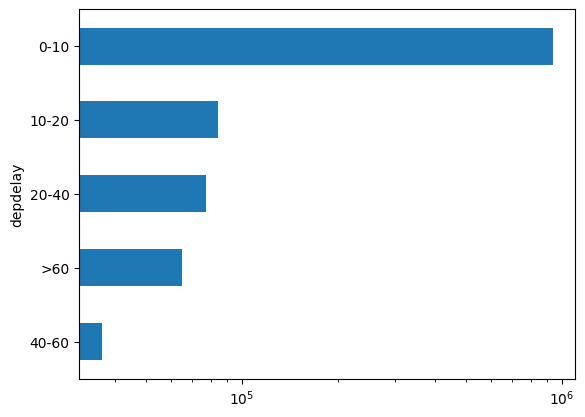

In [115]:
flight_df["depdelay"].value_counts().sort_values().plot(kind = "barh",
                                                        logx = True)

<Axes: ylabel='arrdelay'>

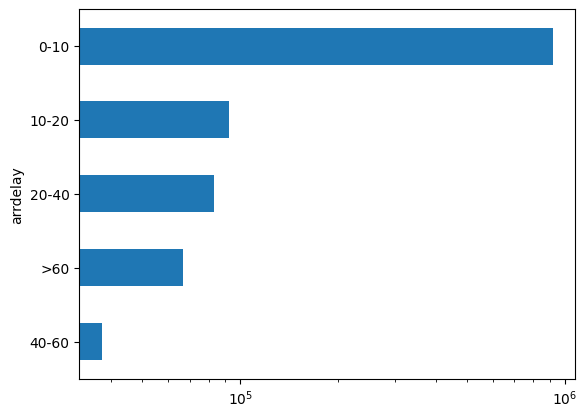

In [116]:
flight_df["arrdelay"].value_counts().sort_values().plot(kind = "barh",
                                                        logx = True)

In [48]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1198458 entries, 0 to 1201663
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   depdelay                 1198458 non-null  int64  
 1   arrdelay                 1198458 non-null  float64
 2   origin                   1198458 non-null  object 
 3   dest                     1198458 non-null  object 
 4   uniquecarrier            1198458 non-null  object 
 5   marketshareorigin        1198458 non-null  float64
 6   marketsharedest          1198458 non-null  float64
 7   hhiorigin                1198458 non-null  float64
 8   hhidest                  1198458 non-null  float64
 9   year                     1198458 non-null  int64  
 10  month                    1198458 non-null  int64  
 11  dayofmonth               1198458 non-null  int64  
 12  dayofweek                1198458 non-null  int64  
 13  scheduledhour            1198458 non-null  int6

In [49]:
ord_cat_features = ["temp_range", "hubairportorigin", "hubairportdest", 
                    "hubairlinedest", "hubairlineorigin", "depdelay"]

hc_cat_features = ["origin", "dest", "uniquecarrier", "tailnum"]

target = "arrdelay"

# Correlation between the columns

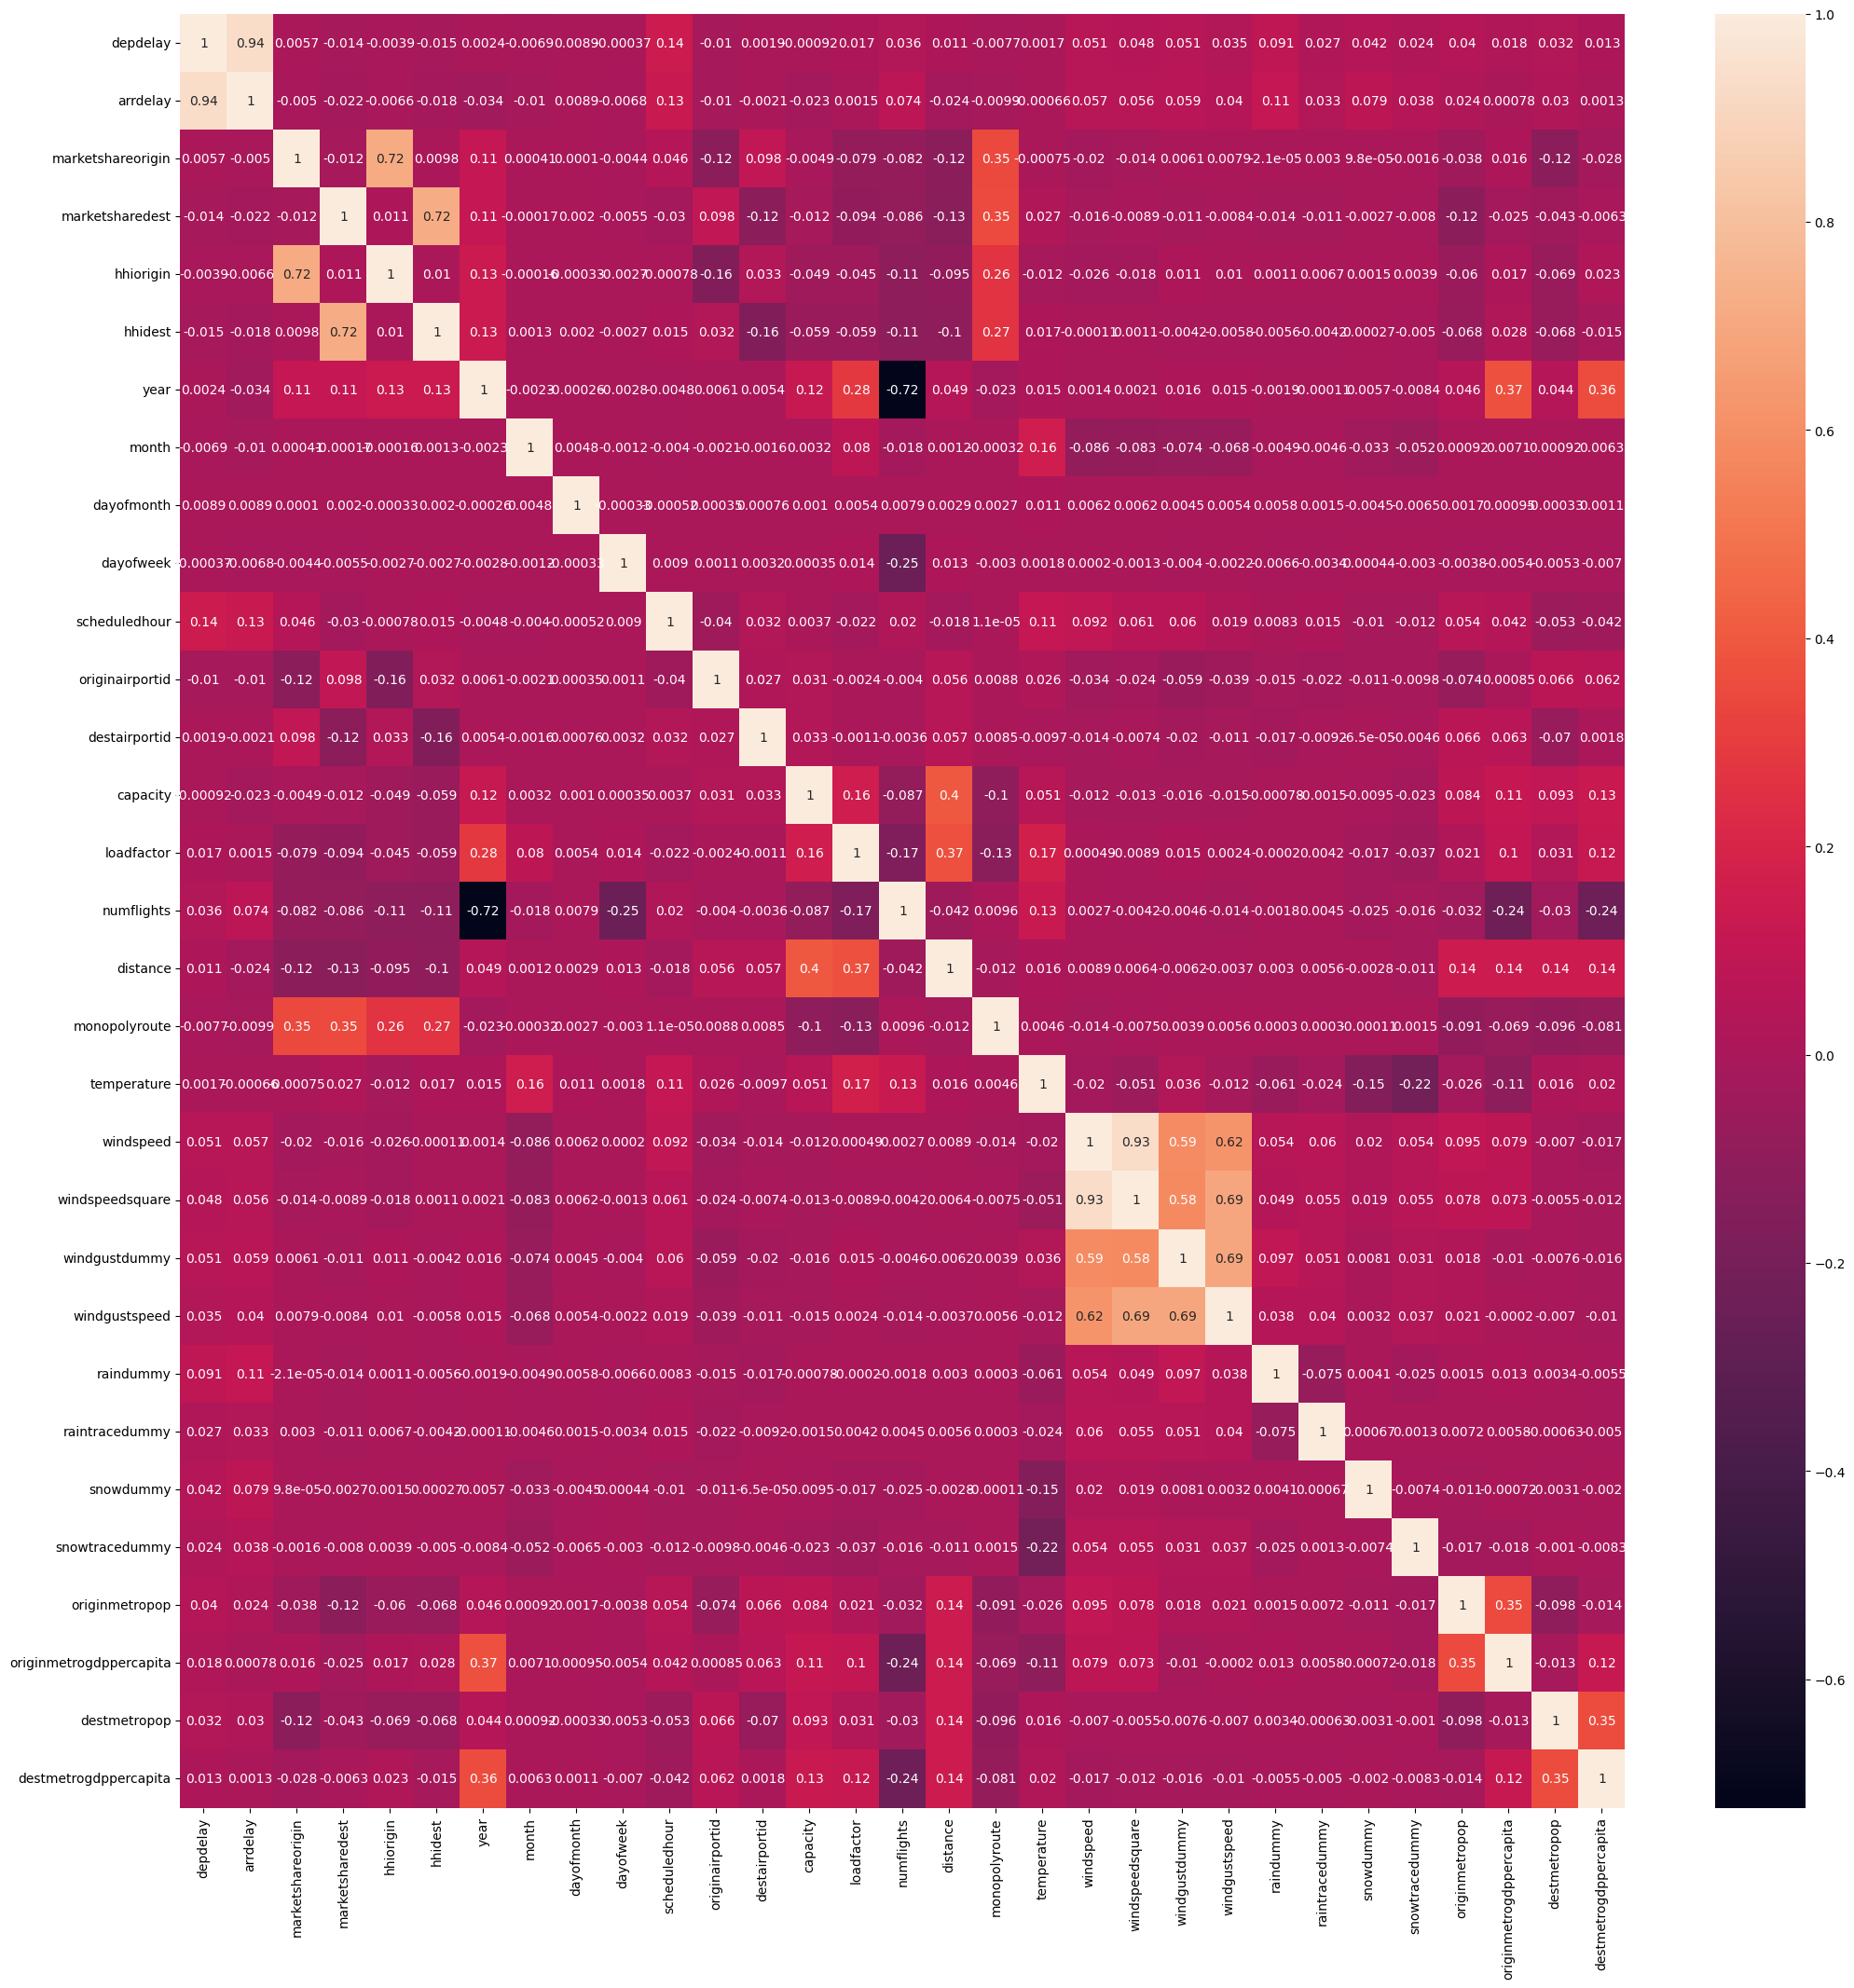

In [14]:
plt.figure(figsize = (25, 25))
sns.heatmap(flight_df.select_dtypes(include = ["float64", "int64"]).corr(), annot = True)
plt.show()

- The weather features associated with wind have a significant correlation between them. The two features, `windspeed` and `windspeedsquare`, have a very high correlation since the latter is the square of the former. Hence, one of the two needs to be dropped.
- The `depdelay` is highly correlated with the target column `arrdelay` and it is expected to be one of the main contributors to the classification.
The features `load factor`, `distance`, and `capacity` have a slight correlation. This makes sense since if the `distance` between the origin and destination is large, then one would prefer to take a flight, and hence, the capacity will be higher. Consequently, the `load factor` will be high for the aircraft.
- It must be noted that `numflights` and `year` have a significant negative correlation.